A semivariogram is a geostatistical concept that quantifies the spatial autocorrelation of a variable over a distance. It is used to assess how similar or dissimilar data points are as a function of their separation distance. Typically, we expect that points closer to each other would be more similar than points that are farther apart from each other. 

The *x*-axis of semivariogram plots is the distance betwen pairs of points and the *y*-axis is the semivariance, which is half the average squared difference between data points separated by a specific lag distance. The resulting empirical spatial structure and spatial dependence of the variable being studied is often captured by a series of theoretical models, including exponential, gaussian, or spherical models. These models have three important components in common, which are the nugget, sill, and range:

1. **Nugget**: The nugget effect represents the semivariance at zero distance. It accounts for measurement error or spatial variation at scales smaller than the smallest sampling interval. A nonzero nugget indicates that there is some degree of variability at very small distances or due to measurement error.

2. **Sill**: The sill of a semivariogram is the value at which the semivariance starts to plateau, indicating that beyond a certain distance, the data points no longer exhibit spatial autocorrelation and become essentially uncorrelated. The sill represents the total variance of the dataset.

3. **Range**: The range is the distance at which the semivariance first reaches the sill. Within the range, data points are spatially correlated to some extent and beyond the range the data points are considered to be independent of one another. The range defines the extent of spatial dependence or autocorrelation.

The semivariance is often defined as half the average squared difference between the values at two points separated by a distance $h$ (Matheron, 1963)

**Exponential Semivariogram Model**

$$\gamma(h) = a + b ~ \Bigg[1 - \exp\Bigg(-\frac{h}{c}\Bigg)\Bigg]$$
where $a$ is the nugget, $b$ is the sill minus the nugget, $h$ is the lag distance, and $c$ is the range.


**Spherical Semivariogram Model**
$$\gamma(h) = a + b \Bigg(\frac{3h}{2c} - \frac{h^3}{2c^3}\Bigg)$$ for $h ≤ c$, and $\gamma(h) = a + b$ for $h > c$

where $a$ is the nugget, $b$ is the sill minus the nugget, $h$ is the lag distance, and $c$ is the range.


**Gaussian Semivariogram Model**
$$\gamma(h) = a + b \Bigg[1 - \exp\Bigg(-\frac{h^2}{c^2}\Bigg)\Bigg]$$

where $a$ is the nugget, $b$ is the sill minus the nugget, $h$ is the lag distance, and $c$ is the range.


## Should I detrend the data first?

A semivariogram should ideally capture the spatial autocorrelation of the variable of interest. The decision to fit a semivariogram on the actual data or the residuals of the detrended data depends on the presence and nature of any trends or deterministic components in the dataset. 

### Use actual data when
the spatial data is relatively homogeneous and does not exhibit strong trends or systematic changes over space. In this case, the spatial data might be considered stationary, meaning its statistical properties (mean and variance) do not change substnatially over the area of interest.

### Detrended data when
spatial dataset exhibits trends or gradients (non-stationarity), where the mean of the process changes over space. For example, soil moisture might higher in areas with depressions. If such trends are present, fitting a semivariogram directly to the actual data can lead to misleading results, because the semivariogram might capture the trend as part of the spatial autocorrelation, which would not be correct.

To address this issue, we can fit either a deterministic or statistical model (a surface) to the dataset and remove the trend from the data. The residuals from this model (the differences between the observed values and the fitted trend values) are then used to fit the semivariogram. These residuals represent the spatial variability after accounting for the trend, providing a clearer picture of the spatial autocorrelation that exists independently of the trend.


In [37]:
# Import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [38]:
# Define three common semivariogram models

def exponential_model(h,n,s,r):
    """
    Exponential semivariogram
    Input
        h = lag distances
        n = nugget
        s = sill
        r = range
    
    Returns
        semivariance for each corresponding lag value.
    """
    
    # Calculate the semivariance (g is for gamma)
    g = n + (s-n) * (1-np.exp(-h/r))
    g = np.maximum(g, 0)
    return g


def spherical_model(h,n,s,r):
    """
    Spherical semivariogram
    Input
        h = lag distances
        n = nugget
        s = sill
        r = range
    
    Returns
        semivariance for each corresponding lag value
    """
    
    # Calculate the semivariance (g is for gamma)
    g = n + (s-n) * ((3*h)/(2*r)  - 1/2*(h/r)**3)
    g[h>r] = s
    g = np.maximum(g, 0)
    return g


def gaussian_model(h,n,s,r):
    """
    Gaussian semivariogram
    Input
        h = lag distances
        n = nugget
        s = sill
        r = range
    
    Returns
        semivariance for each corresponding lag value.
    """
    
    # Calculate the semivariance (g is for gamma)
    g = n + (s-n) * (1 - np.exp(-h**2 / r**2))
    g = np.maximum(g, 0)
    return g


In [39]:
# Define coordiante reference systems
crs_utm = 32614 # UTM Zone 14
crs_wgs = 4326 # WGS84

We will begin by reading the data using the Pandas library. While we can do this step using the GeoPandas library, using Pandas will allow us to designate missing values that are replaced with `NaN` and then drop these rows with missing values. In other words, these steps are trivial in Pandas, but will take several lines of code in GeoPandas.

In [40]:
# Read data using Pandas
df = pd.read_csv('../datasets/spatial/soil_moisture_surveys/kona_15_jul_2019.csv')

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(3)


,TimeStamp,Record,Zone,Latitude,Longitude,Moisture,Period,Attenuation,Permittivity,Probe Model,Sensor
0,7/15/2019 7:15,320,ZONE 00001,39.11060,-96.61089,38.88,1.6988,1.8181,23.8419,CD659 12cm rods,3543
1,7/15/2019 7:17,321,"ZONE 00001, ZONE 00011",39.11058,-96.61116,41.71,1.7474,1.8310,26.7794,CD659 12cm rods,3543
2,7/15/2019 7:17,322,"ZONE 00001, ZONE 00011",39.11055,-96.61146,40.59,1.7271,1.7911,25.5712,CD659 12cm rods,3543


In [41]:
# Convert Pandas Dataframe into GeoPandas GeoDataframe
gdf = gpd.GeoDataFrame(df)


In [42]:
# Add Point geometry from lat and long values
gdf['points'] = gpd.points_from_xy(gdf['Longitude'], gdf['Latitude'])
gdf.set_geometry('points', drop=True, inplace=True, crs=crs_wgs)


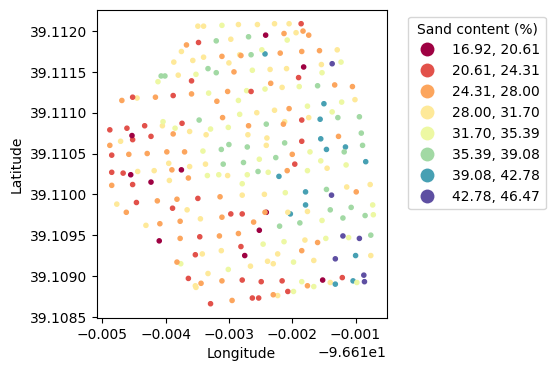

In [43]:
# Inspect spatial data
plt.figure(figsize=(5,4))
gdf.plot(ax=plt.gca(), marker='.', column='Moisture',
         cmap='Spectral', scheme='equal_interval', k=8, legend=True,
         legend_kwds={'loc':'upper left', 
                      'bbox_to_anchor':(1.05,1),
                      'title':'Sand content (%)'})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [44]:
# Convert point coordinates to UTM, so that we can work in meters to compute distances within the field
gdf.to_crs(crs=crs_utm, inplace=True)


In [45]:
# Get x and y coordinates from Point geometry
x = gdf['geometry'].x.values
y = gdf['geometry'].y.values
z = gdf['Moisture'].values

## Detrend dataset

In [46]:
# Define simple linear model for removing the main trend in a dataset
detrend_model = lambda data,b0,b1,b2: b0 + b1*data[0] + b2*data[1]

# Fit simple detrend model to data
popt, pcov = curve_fit(detrend_model,[x,y],z)
print(popt)

# Create trend surface using observed x and y coordinates
z_trend = detrend_model([x,y], *popt)

# Remove trend from data (resulting in residuals)
z_res = z - z_trend


[-4.67047351e+04  2.96492268e-02  5.95374753e-03]


In [47]:
# Set maximum distance (useful to trim distance with low point density)
max_dist = 200 # Approximately the radius of the field


In [48]:
# Compute square differences

# Pre-allocate arrays
dist = np.array([])
sq_diff = np.array([])

for k in range(gdf.shape[0]):
    
    # Compute distance from all points to current point
    dist_new = gdf["geometry"].distance(gdf.loc[k, 'geometry']).values
    
    # Remove distances and corresponding square differences beyong max distance
    idx_range = dist_new <= max_dist
    dist_new = dist_new[idx_range]
    dist = np.concatenate( (dist, dist_new)) 
    
    # Compute square difference between all points and current point
    sq_diff_new = (z_res - z_res[k])**2
    sq_diff_new = sq_diff_new[idx_range]
    sq_diff = np.concatenate( (sq_diff, sq_diff_new) )
    

## Create bins

We will aggregate the distance data into different bins and then compute the mean distance value for each bin and the semivariance for the points within the bins. This step will reduce the noise among all the pairs of data points.

In [49]:
# Create bins to ompute semivariance
bin_edges = np.histogram_bin_edges(dist, bins='sturges')

N_bins = bin_edges.shape[0] - 1

# Pre-allocate arrays
G = np.full(N_bins, np.nan)
H = np.full(N_bins, np.nan)

for k in range(N_bins):
    
    # Find distances inside current bin edges
    idx_bin = (dist >= bin_edges[k]) & (dist < bin_edges[k+1])
    
    # Semi-variance
    N_points_in_bin = sum(idx_bin) 
    G[k] = np.sum(sq_diff[idx_bin])/(2*N_points_in_bin)
    
    # Mean distance of bin
    H[k] = np.nanmean(dist[idx_bin])
    

## Fit semivariogram models

In this part we will fit the semivariogram models to the lags and semivariance values determined from observations. The goal is to obtain nugget, sill and range parameter values.

In [50]:
# Fit semivariogram
x_curve = np.linspace(dist.min(), dist.max(), 100)

bounds = ([0,0,0],[10,200,250])
p0 = [0,100,100]

# Fit exponential semivariogram
par_opt, par_cov = curve_fit(exponential_model, H, G, p0=p0, bounds=bounds)
y_curve_exponential = exponential_semivariogram(x_curve, *par_opt)
print('Exponential semivariogram')
print('Nugget:', par_opt[0])
print('Sill:', par_opt[1])
print('Range:', par_opt[2])
print('')

# Fit spherical semivariogram
par_opt, par_cov = curve_fit(spherical_model, H, G, p0=p0, bounds=bounds)
y_curve_spherical = spherical_semivariogram(x_curve, *par_opt)
print('Spherical semivariogram')
print('Nugget:', par_opt[0])
print('Sill:', par_opt[1])
print('Range:', par_opt[2])
print('')

# Fit gaussian semivariogram
par_opt, par_cov = curve_fit(gaussian_model, H, G, p0=p0, bounds=bounds)
y_curve_gaussian = gaussian_model(x_curve, *par_opt)
print('Gaussian model')
print('Nugget:', par_opt[0])
print('Sill:', par_opt[1])
print('Range:', par_opt[2])
print('')


Exponential semivariogram
Nugget: 2.2313140492496877
Sill: 27.677558136925335
Range: 15.021035487726436

Spherical semivariogram
Nugget: 3.6731705492105142
Sill: 27.3527330179765
Range: 37.26962520602393

Gaussian model
Nugget: 5.39282929382767
Sill: 27.348291429320234
Range: 17.759669374177392



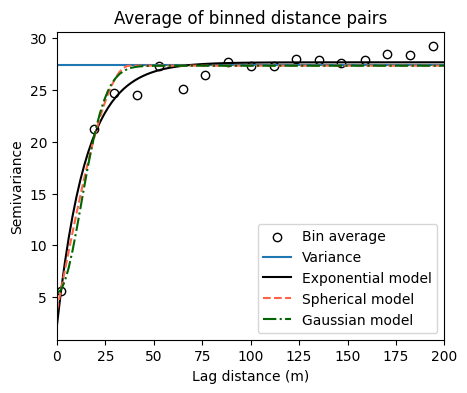

In [51]:
# Visualize fitted semivariograms with all free parameters
plt.figure(figsize=(5,4))

plt.title('Average of binned distance pairs')
plt.scatter(H, G, facecolor='w', edgecolor='k', label='Bin average')
plt.axhline(np.nanvar(z_res), label='Variance')
plt.plot(x_curve, y_curve_exponential, linestyle='-',
         color='k', label='Exponential model')

plt.plot(x_curve, y_curve_spherical, linestyle='--', 
         color='tomato',label='Spherical model')

plt.plot(x_curve, y_curve_gaussian, linestyle='-.',
         color='darkgreen', label='Gaussian model')
plt.xlabel('Lag distance (m)')
plt.ylabel('Semivariance')
plt.xlim([0, max_dist])
plt.legend()

plt.show()


## Fit semivariogram models with forced nugget

Perhaps the most difficult parameter to obtain is the nugget. This could be attributed to noise, measurement error, or a lack of observations in close proximity to other observations. One option to resolve this issue is to force the nugget to adopt a specific value, like zero. The following code illustrates how to use a lambda function to re-define our semivariogram models and conduct the fitting exercise by forcing the nugget to a specific value.

In [52]:
# We no longer need to initial value and bounds of the nugget
bounds = ([0,0],[200,250])
p0 = [100,100]

# Fit exponential semivariogram
custom_exponential = lambda x,s,r: exponential_model(x,0,s,r)
par_opt, par_cov = curve_fit(custom_exponential, H, G, p0=p0, bounds=bounds)
y_curve_exponential = custom_exponential(x_curve, *par_opt)
print('Sill:', par_opt[0])
print('Range:', par_opt[1])
print('')

# Fit spherical semivariogram
custom_spherical = lambda x,s,r: spherical_model(x,0,s,r)
par_opt, par_cov = curve_fit(custom_spherical, H, G, p0=p0, bounds=bounds)
y_curve_spherical = custom_spherical(x_curve, *par_opt)
print('Sill:', par_opt[0])
print('Range:', par_opt[1])
print('')

# Fit gaussian semivariogram
custom_gaussian = lambda x,s,r: gaussian_model(x,0,s,r)
par_opt, par_cov = curve_fit(custom_gaussian, H, G, p0=p0, bounds=bounds)
y_curve_gaussian = custom_gaussian(x_curve, *par_opt)
print('Sill:', par_opt[0])
print('Range:', par_opt[1])
print('')


Sill: 27.590490177346954
Range: 13.437192299909409

Sill: 27.304270167041153
Range: 33.898517105146944

Sill: 27.293590546520043
Range: 15.86777183412689



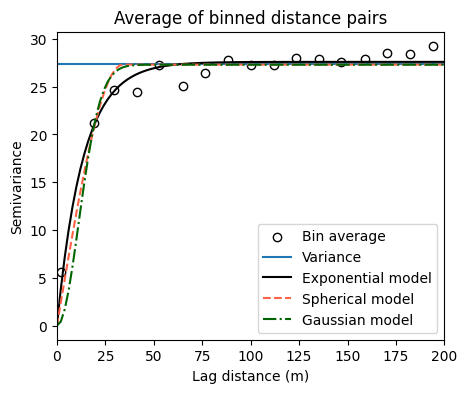

In [53]:
# Visualize fitted semivariogram models with forced nugget
plt.figure(figsize=(5,4))

plt.title('Average of binned distance pairs')
plt.scatter(H, G, facecolor='w', edgecolor='k', label='Bin average')
plt.axhline(np.var(z_res), label='Variance')
plt.plot(x_curve, y_curve_exponential, linestyle='-',
         color='k', label='Exponential model')

plt.plot(x_curve, y_curve_spherical, linestyle='--', 
         color='tomato',label='Spherical model')

plt.plot(x_curve, y_curve_gaussian, linestyle='-.',
         color='darkgreen', label='Gaussian model')
plt.xlabel('Lag distance (m)')
plt.ylabel('Semivariance')
plt.xlim([0, max_dist])
plt.legend()

plt.show()

## Practice

- In order to determine the best semivariogram model, compute the mean absolute error (MAE) of the fitted models and find the model with the lowest MAE.

## References

Matheron, G. (1963). Principles of geostatistics. Economic geology, 58(8), 1246-1266. [https://doi.org/10.2113/gsecongeo.58.8.1246](https://doi.org/10.2113/gsecongeo.58.8.1246)